In [6]:
# Hierarchical Clustering - Improved Version

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [7]:
# Load data
df = pd.read_csv("Mall_Customers.csv")

In [8]:
# First five row
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
# Rename columns for convenience
df.rename(columns={'Annual Income (k$)': 'Annual_income', 'Spending Score (1-100)': 'Spending_score'}, inplace=True)

In [10]:
# Data info
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual_income   200 non-null    int64 
 4   Spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual_income  Spending_score
count  200.000000  200.000000     200.000000      200.000000
mean   100.500000   38.850000      60.560000       50.200000
std     57.879185   13.969007      26.264721       25.823522
min      1.000000   18.000000      15.000000        1.000000
25%     50.750000   28.750000      41.500000       34.750000
50%    100.500000   36.000000      61.500000       50.000000
75%    150.250000   49.000000      78.000000       73.000000
max    200.000000   70.000000     137.000000 

In [11]:
# Check for nulls
print(df.isnull().sum())

CustomerID        0
Gender            0
Age               0
Annual_income     0
Spending_score    0
dtype: int64


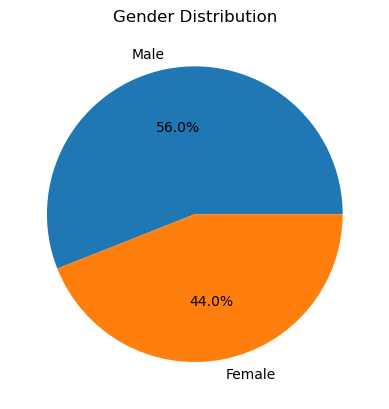

In [12]:
# Gender distribution
plt.pie(df['Gender'].value_counts(), labels=df['Gender'].unique(), autopct='%1.1f%%')
plt.title("Gender Distribution")
plt.show()


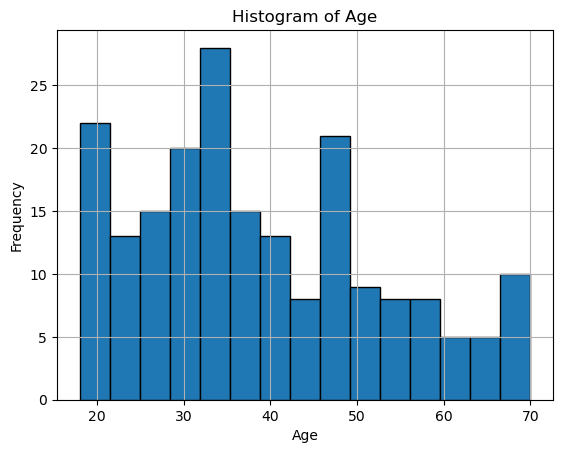

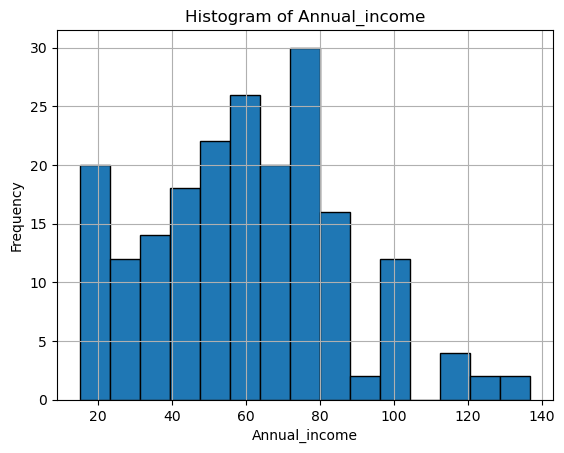

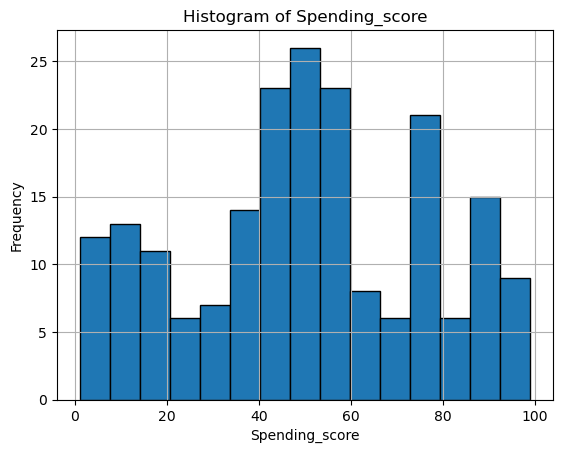

In [13]:
# Histograms
cols = ['Age', 'Annual_income', 'Spending_score']
for col in cols:
    plt.hist(df[col], bins=15, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

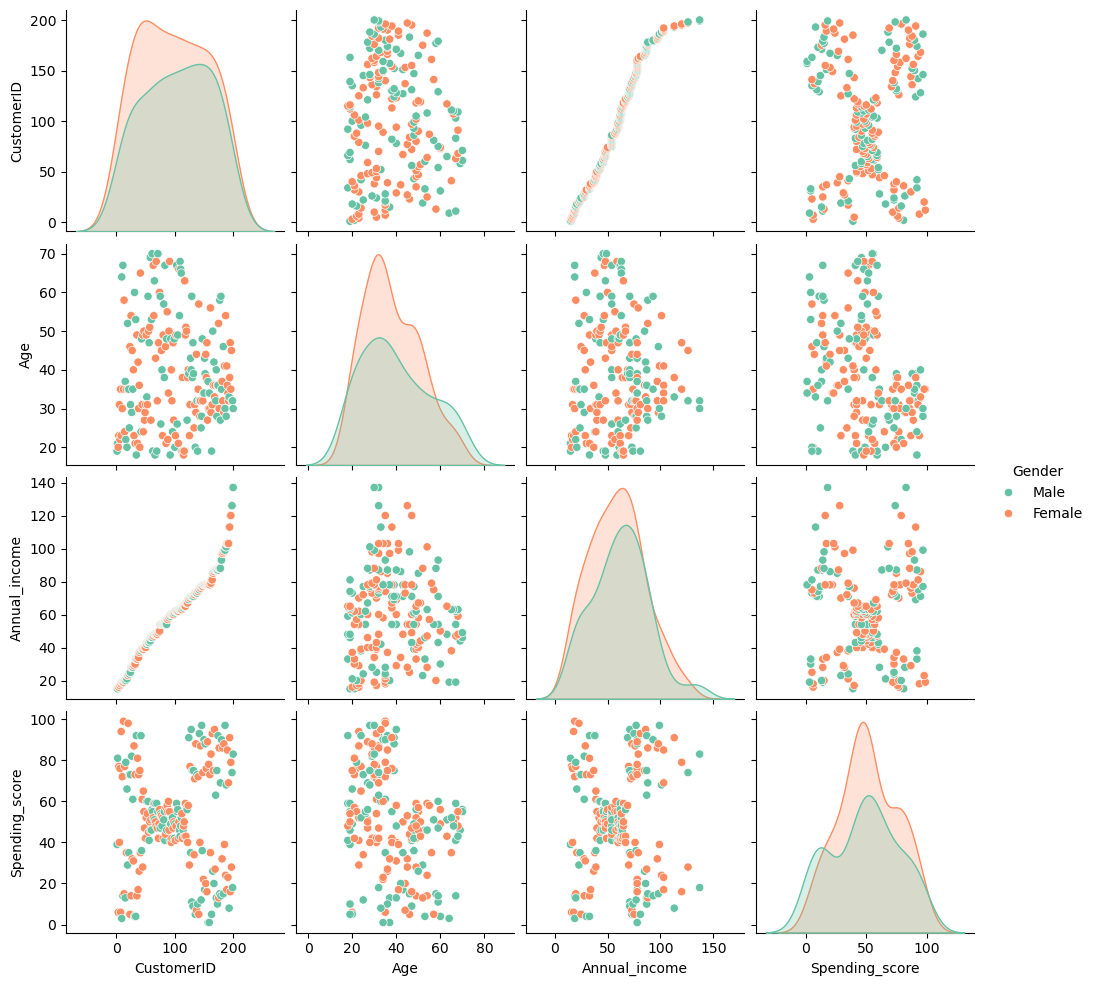

In [14]:
# Pairplot
sns.pairplot(df, hue='Gender', palette='Set2')
plt.show()


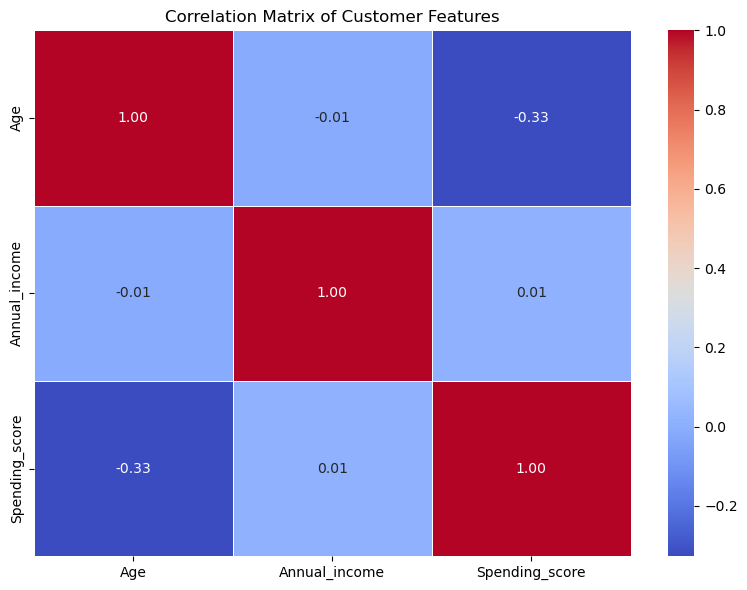

In [15]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
corr = df[['Age', 'Annual_income', 'Spending_score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Customer Features")
plt.tight_layout()
plt.show()


In [16]:
# Feature selection
X = df[['Age', 'Annual_income', 'Spending_score']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

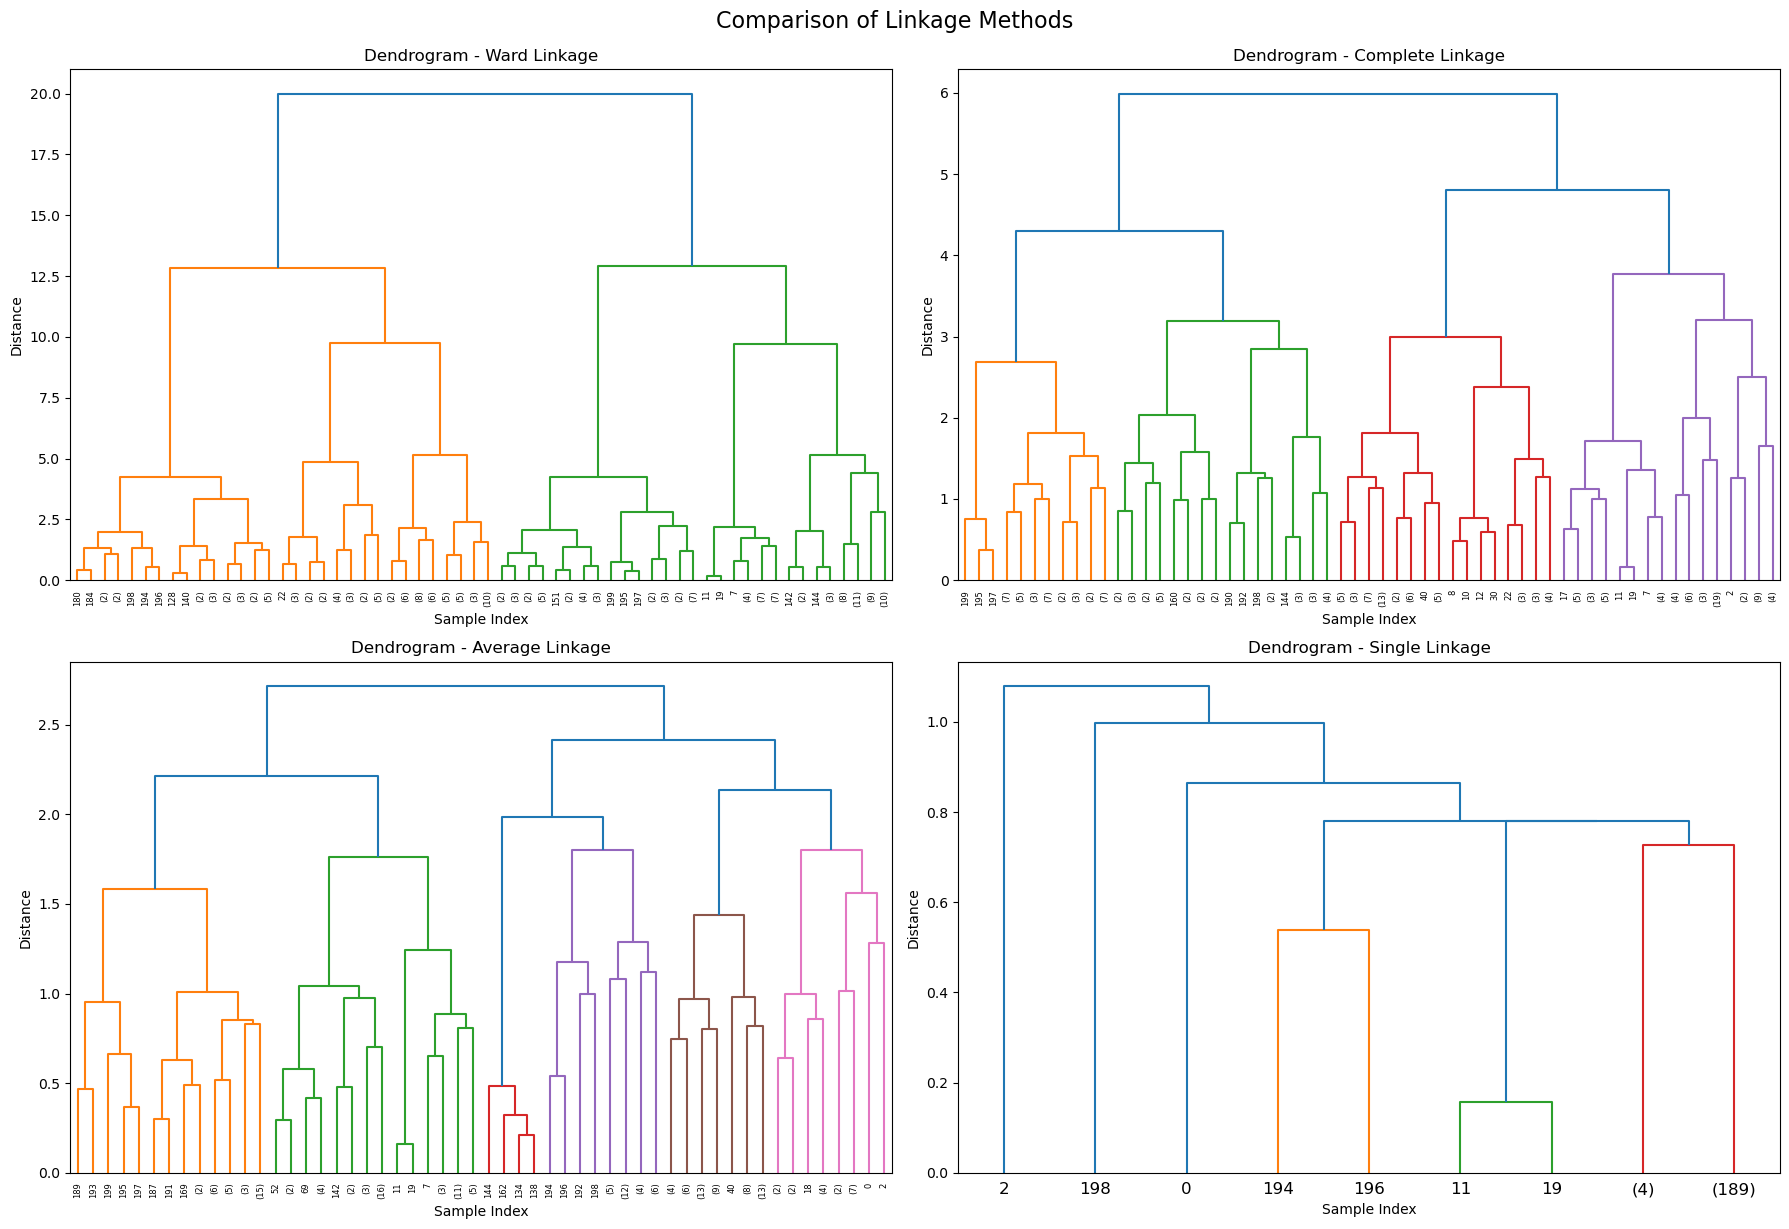

In [17]:
# Side-by-side Dendrograms for Linkage Comparison

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Scale your data if you haven't already
X = df[['Age', 'Annual_income', 'Spending_score']]
X_scaled = StandardScaler().fit_transform(X)

# Define linkage methods to compare
linkage_methods = ['ward', 'complete', 'average', 'single']

# Plot 4 dendrograms
plt.figure(figsize=(18, 12))
for i, method in enumerate(linkage_methods):
    plt.subplot(2, 2, i + 1)
    Z = linkage(X_scaled, method=method)
    dendrogram(Z, truncate_mode='level', p=5)
    plt.title(f'Dendrogram - {method.capitalize()} Linkage')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')

plt.tight_layout()
plt.suptitle('Comparison of Linkage Methods', fontsize=16, y=1.02)
plt.show()


We compared Ward, Complete, Average, and Single linkage methods. Based on dendrogram compactness and interpretability, we selected Ward linkage for final clustering

In [18]:
# Determine the best linkage method using Silhouette Score
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_scores = {}

print("Evaluating linkage methods using Silhouette Score...")
for method in linkage_methods:
    try:
        model = AgglomerativeClustering(n_clusters=5, linkage=method)
        labels = model.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores[method] = score
        print(f"Silhouette Score ({method} linkage): {score:.4f}")
    except Exception as e:
        print(f"Could not evaluate {method}: {e}")


Evaluating linkage methods using Silhouette Score...
Silhouette Score (ward linkage): 0.3900
Silhouette Score (complete linkage): 0.4000
Silhouette Score (average linkage): 0.4096
Silhouette Score (single linkage): 0.0030


Comments:
* Ward Linkage (0.3900): Performs well, creates compact, spherical clusters — often preferred for Euclidean distances.

* Complete Linkage (0.4000): Slightly better than Ward, tends to create more evenly sized clusters and is robust to noise.

* Average Linkage (0.4096) - best method: Best performer in this case — balances between compactness and flexibility, yielding better separation.

* Single Linkage (0.0030) - Very poor — forms “chained” clusters, sensitive to outliers and noise, not ideal here.

The Average linkage method produced the highest Silhouette Score (0.4096), indicating the most cohesive and well-separated clusters among the four.

Ward and Complete linkage methods also performed reasonably well but were slightly outperformed.

Single linkage resulted in a very low score, confirming it is not suitable for this dataset — it likely formed elongated, poorly separated clusters ("chaining effect").

Conclusion:

Based on these results, it is justified and appropriate to use Average linkage for your final hierarchical clustering model. This reflects good model selection practice using internal validation metrics.



In [19]:

# Apply final Hierarchical Clustering using the best method (average linkage)
cluster = AgglomerativeClustering(n_clusters=5, linkage='average')
df['HierarchicalCluster'] = cluster.fit_predict(X_scaled)


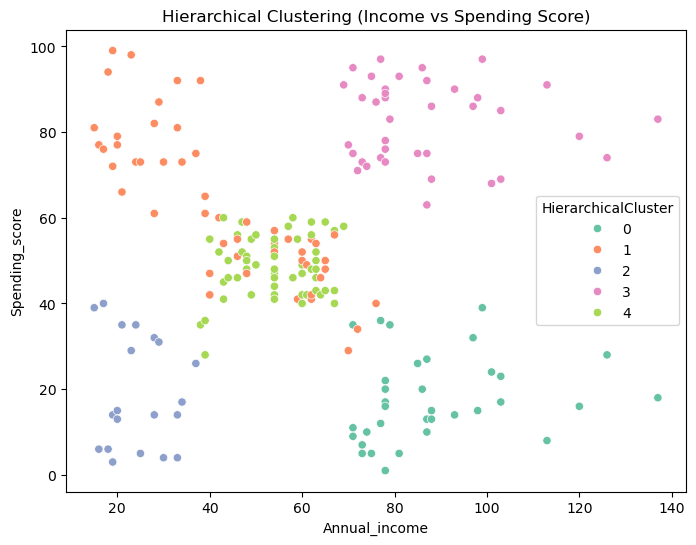

In [20]:
# 2D Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Annual_income', y='Spending_score', hue='HierarchicalCluster', palette='Set2')
plt.title('Hierarchical Clustering (Income vs Spending Score)')
plt.show()

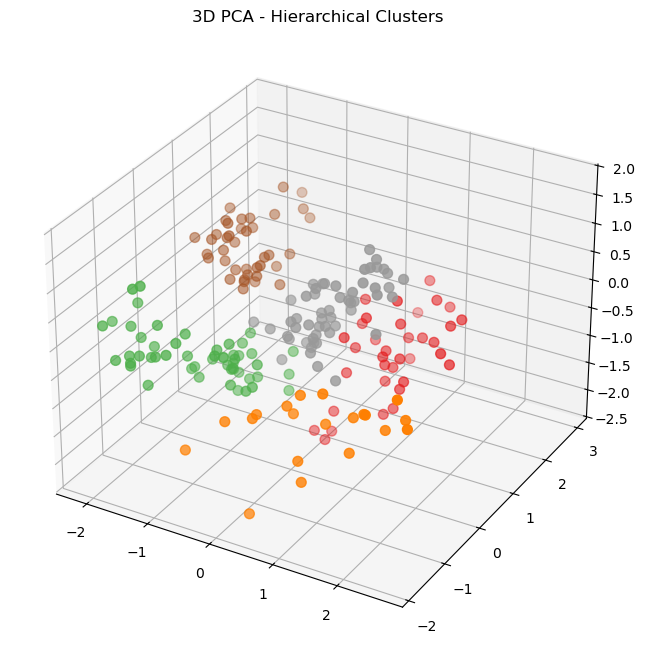

In [21]:
# 3D Plot using PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=df['HierarchicalCluster'], cmap='Set1', s=50)
plt.title("3D PCA - Hierarchical Clusters")
plt.show()

In [22]:
# Cluster profiling
cluster_profiles = df.groupby('HierarchicalCluster')[['Age', 'Annual_income', 'Spending_score']].mean()
print("Cluster Profiles:")
print(cluster_profiles)

Cluster Profiles:
                           Age  Annual_income  Spending_score
HierarchicalCluster                                          
0                    41.685714      88.228571       17.285714
1                    24.653846      42.942308       62.076923
2                    43.900000      24.450000       19.100000
3                    32.692308      86.538462       82.128205
4                    53.259259      54.203704       48.555556


/var/folders/rz/5557d_s539ggxzyvpnw_d2vm0000gn/T/ipykernel_23885/363651115.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='HierarchicalCluster', palette='Set2')


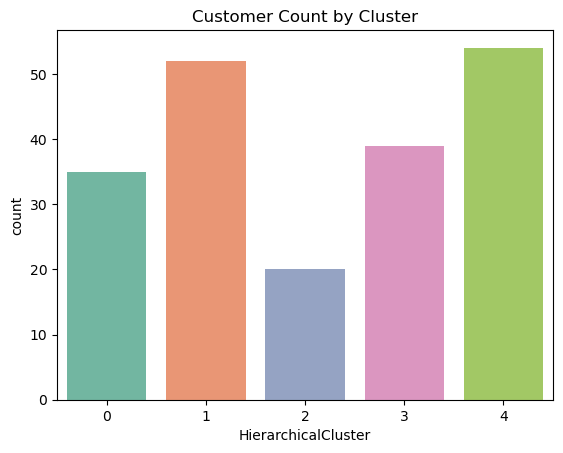

/var/folders/rz/5557d_s539ggxzyvpnw_d2vm0000gn/T/ipykernel_23885/363651115.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HierarchicalCluster', y=col, data=df, palette='Set2')


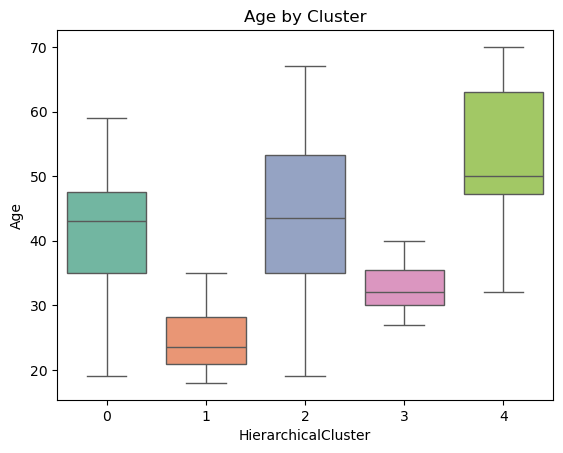

/var/folders/rz/5557d_s539ggxzyvpnw_d2vm0000gn/T/ipykernel_23885/363651115.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HierarchicalCluster', y=col, data=df, palette='Set2')


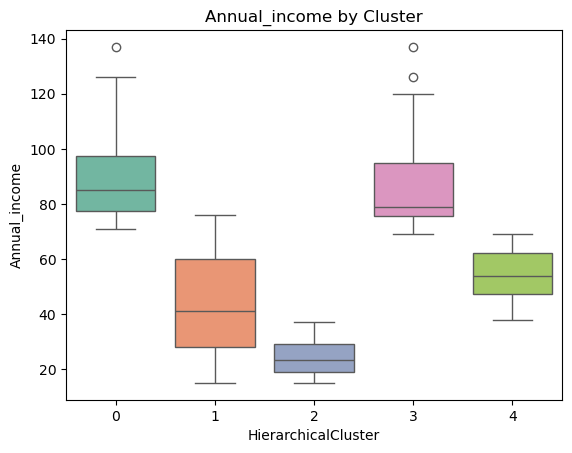

/var/folders/rz/5557d_s539ggxzyvpnw_d2vm0000gn/T/ipykernel_23885/363651115.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HierarchicalCluster', y=col, data=df, palette='Set2')


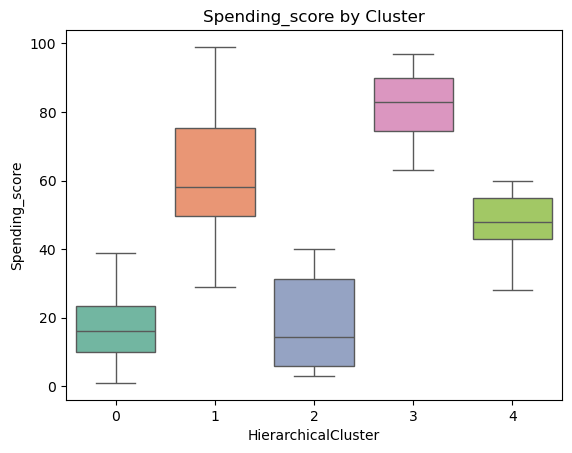

In [23]:
sns.countplot(data=df, x='HierarchicalCluster', palette='Set2')
plt.title("Customer Count by Cluster")
plt.show()

for col in ['Age', 'Annual_income', 'Spending_score']:
    sns.boxplot(x='HierarchicalCluster', y=col, data=df, palette='Set2')
    plt.title(f'{col} by Cluster')
    plt.show()


In [24]:
import pandas as pd

# Load your dataset
# Assuming you already have the dataset loaded as 'df'
# Example structure: df = pd.read_csv('customer_data.csv')

# Create derived features
df['Income_to_Spending_Ratio'] = df['Spending_score'] / df['Annual_income']
df['Age_Group'] = pd.cut(
    df['Age'], 
    bins=[0, 30, 50, 100], 
    labels=['Young', 'Middle-aged', 'Senior']
)

# Display the updated dataset
print(df.head())

# Optional: Verify summary statistics of the new features
print(df[['Income_to_Spending_Ratio']].describe())
print(df['Age_Group'].value_counts())


   CustomerID  Gender  Age  Annual_income  Spending_score  \
0           1    Male   19             15              39   
1           2    Male   21             15              81   
2           3  Female   20             16               6   
3           4  Female   23             16              77   
4           5  Female   31             17              40   

   HierarchicalCluster  Income_to_Spending_Ratio    Age_Group  
0                    2                  2.600000        Young  
1                    1                  5.400000        Young  
2                    2                  0.375000        Young  
3                    1                  4.812500        Young  
4                    2                  2.352941  Middle-aged  
       Income_to_Spending_Ratio
count                200.000000
mean                   1.068544
std                    0.973406
min                    0.012821
25%                    0.632803
50%                    0.887993
75%                    1.

In [25]:
# Define age groups
def categorize_age(age):
    if age < 25:
        return "Young"
    elif 25 <= age < 50:
        return "Middle-aged"
    else:
        return "Senior"

# Apply function to create a new column
df["Age Group"] = df["Age"].apply(categorize_age)

# Display the updated DataFrame
print(df)

     CustomerID  Gender  Age  Annual_income  Spending_score  \
0             1    Male   19             15              39   
1             2    Male   21             15              81   
2             3  Female   20             16               6   
3             4  Female   23             16              77   
4             5  Female   31             17              40   
..          ...     ...  ...            ...             ...   
195         196  Female   35            120              79   
196         197  Female   45            126              28   
197         198    Male   32            126              74   
198         199    Male   32            137              18   
199         200    Male   30            137              83   

     HierarchicalCluster  Income_to_Spending_Ratio    Age_Group    Age Group  
0                      2                  2.600000        Young        Young  
1                      1                  5.400000        Young        Young  
2     

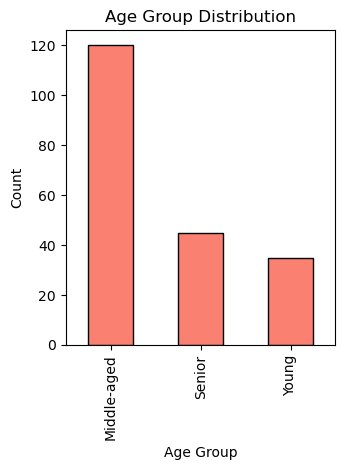

In [26]:
# Calculate age group distribution
age_group_distribution = df['Age Group'].value_counts()

# Plot 2: Age Group Distribution
plt.subplot(1, 2, 2)
pd.Series(age_group_distribution).plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

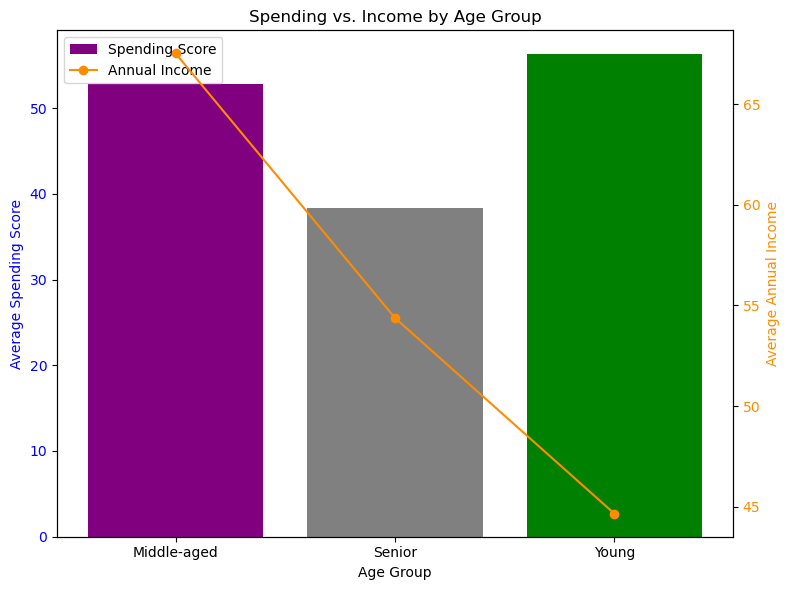

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Group by 'Age Group' and calculate mean values for Annual_income and Spending_score
grouped = df.groupby("Age Group").agg({
    "Annual_income": "mean",
    "Spending_score": "mean"
}).reset_index()

# Define a color mapping for each Age Group
color_mapping = {"Young": "green", "Middle-aged": "purple"}
bar_colors = [color_mapping.get(age, "gray") for age in grouped["Age Group"]]

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the average spending score as bars on the primary y-axis with colors by Age Group
bars = ax1.bar(grouped["Age Group"], grouped["Spending_score"], color=bar_colors, label='Spending Score')
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Average Spending Score", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Spending vs. Income by Age Group")

# Create a second y-axis to plot the average annual income as a line plot
ax2 = ax1.twinx()
ax2.plot(grouped["Age Group"], grouped["Annual_income"], color='darkorange', marker='o', label='Annual Income')
ax2.set_ylabel("Average Annual Income", color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()


The plot indicates a clear relationship between average annual income and spending score: those with higher incomes (middle-aged) exhibit higher spending scores, whereas those with lower incomes (young) exhibit lower spending scores. Seniors sit in the middle for both measures. This pattern is typical in many markets, where disposable income often increases until middle age, then may taper off slightly for seniors, while younger adults typically have the least disposable income—and hence lower spending.